# Re-intubation

The purpose of this notebook is to calculate the times between subsequent episodes of mechanical ventilation for each patient. Once this is completed, episodes of ventilation that meet the following criteria are selected:
- episode of ventilation is the first for that patient (subsequent ventilator episodes are excluded).
- ventilation lasts at least 6 hours (to ensure enough data has been collected).

Finally, extubation failure is defined as a patient requiring re-intubation within 48 hours of being extubated. Success is defined as a patient never requiring re-intubation. This excludes any patients who were re-intubated, but who don't meet the criteria of failure as it happened more than 48 hours after extubation.

Two pandas DataFrames are created and saved in **"data/re_intubation.npy"**.

The column names in ***patients*** are:
- **subject_id** - patient identifier.
- **hadm_id** - hospital admission identifier.
- **icustay_id** - ICU admission identifier.
- **gender, dob, age** - self-explanatory.
- **admittime, dischtime** - time of hospital admission and discharge.
- **intime, outtime** - time of ICU admission and discharge.
- **los** - length of ICU stay in days.
- **diagnosis** - free text diagnosis usually assigned by the admitting clinician.
- **hospital_expire_flag** - whether the patient died during that hospital stay or not.
- **ventnum** - the number of times they were placed on mechanical ventilation.
- **success** - True if the patient was never re-intubated.
- **failure** - True if the patient was re-intubated within 48 hours of being extubated.

The column names in ***ri_times*** are:
- **icustay_id** - ICU admission identifier.
- **ventprev** - the first instance of mechanical ventilation for that ICU stay (should always be 1).
- **endtime** - time at which the patient was extubated.
- **ventsub** - the next instance of mechanical ventilation for that ICU stay (should always be 2, if re-intubated; or 0, if never re-intubated).
- **starttime** - time at which the patient was re-intubated (0 if they were never re-intubated).
- **timediff** - time between extubation and re-intubation (0 if they were never re-intubated).
- **success** - True if the patient was never re-intubated.
- **failure** - True if the patient was re-intubated within 48 hours of being extubated.

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import psycopg2
import getpass
import os.path
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the database connection details
_data = np.load('data/db_details.npy', allow_pickle=True).tolist()
db_details = _data['db_details']
user = db_details['user']
host = db_details['host']
port = db_details['port']
dbname = db_details['dbname']
schema = db_details['schema']
    
# Connect to the database
conn = psycopg2.connect(dbname=dbname, user=user, host=host, port=port, password=getpass.getpass(prompt='Password:'.format(user)))
cur = conn.cursor()
cur.execute('SET search_path TO {}'.format(schema))
conn.commit()

Password: ··········


In [3]:
# Load the patient data
_data = np.load('data/patients.npy', allow_pickle=True).tolist()
patients = _data['patients']
mech_vent = _data['mech_vent']
print("Loaded!")

Loaded!


In [4]:
# Show some sample data
mech_vent.head()

,icustay_id,ventnum,starttime,endtime,duration_hours
0,200003.0,1,2199-08-03 18:00:00,2199-08-07 13:00:00,91.000000
1,200006.0,1,2159-09-03 13:00:00,2159-09-04 03:50:00,14.833333
2,200009.0,1,2189-11-30 18:10:00,2189-12-01 10:00:00,15.833333
3,200011.0,1,2188-08-06 01:00:00,2188-08-06 04:00:00,3.000000
4,200014.0,1,2105-02-16 23:15:00,2105-02-17 18:00:00,18.750000


In [5]:
# Initialise place to store results
result = np.zeros((6,))

# Loop over every patient
for icustay_id in np.unique(mech_vent['icustay_id']):
    
    # Select data for one individual patient
    data = np.array(mech_vent[mech_vent['icustay_id']==icustay_id])
    
    # Calculate how many times that patient has been intubated
    max_ventnum = max(data[:,1])

    # Initialise a list to append results to
    patient_list = []

    # Loop over every instance of ventilation for that patient
    for i in range(max_ventnum):
    
        previous_vent = data[i,(0,1,3)] # icustay_id, and previous ventilation number and end time
    
        # Account for cases where there is no re-intubation
        try:
            subsequent_vent = data[i+1,(1,2)] # subsesequent ventilation number and start time
            time_diff = (subsequent_vent[-1] - previous_vent[-1]).total_seconds()/(60*60) # calculates time between extubation and re-intubation in hours
        except:
            subsequent_vent = np.zeros((2,))
            time_diff = 0.0
    
        # Append result to a list for this patient
        patient_list.append(np.concatenate([previous_vent, subsequent_vent, [time_diff]]))

    # Convert patient list to numpy array and append to other results
    patient_list = np.array(patient_list)
    result = np.vstack((result, patient_list))

# Convert result array to pandas DataFrame
ri_times = pd.DataFrame(result[1:], columns=['icustay_id', 'ventprev', 'endtime', 'ventsub', 'starttime', 'timediff'])

# Select first episode of ventilation only
ri_times = ri_times[ri_times['ventprev']==1]

# Discard ventilation episodes that last less than 6 hours
ri_times = ri_times[np.array(mech_vent[mech_vent['ventnum']==1]['duration_hours']>=6)]

# Show some sample data
ri_times[ri_times['ventsub']>0].head()

,icustay_id,ventprev,endtime,ventsub,starttime,timediff
11,200045,1,2116-07-10 23:00:00,2,2116-07-12 07:00:00,32
17,200059,1,2198-02-17 11:00:00,2,2198-02-17 15:00:00,4
24,200063,1,2141-03-15 14:09:00,2,2141-03-16 09:00:00,18.85
31,200077,1,2163-04-15 10:20:00,2,2163-04-16 09:00:00,22.6667
42,200131,1,2176-11-04 11:00:00,2,2176-11-04 13:00:00,2


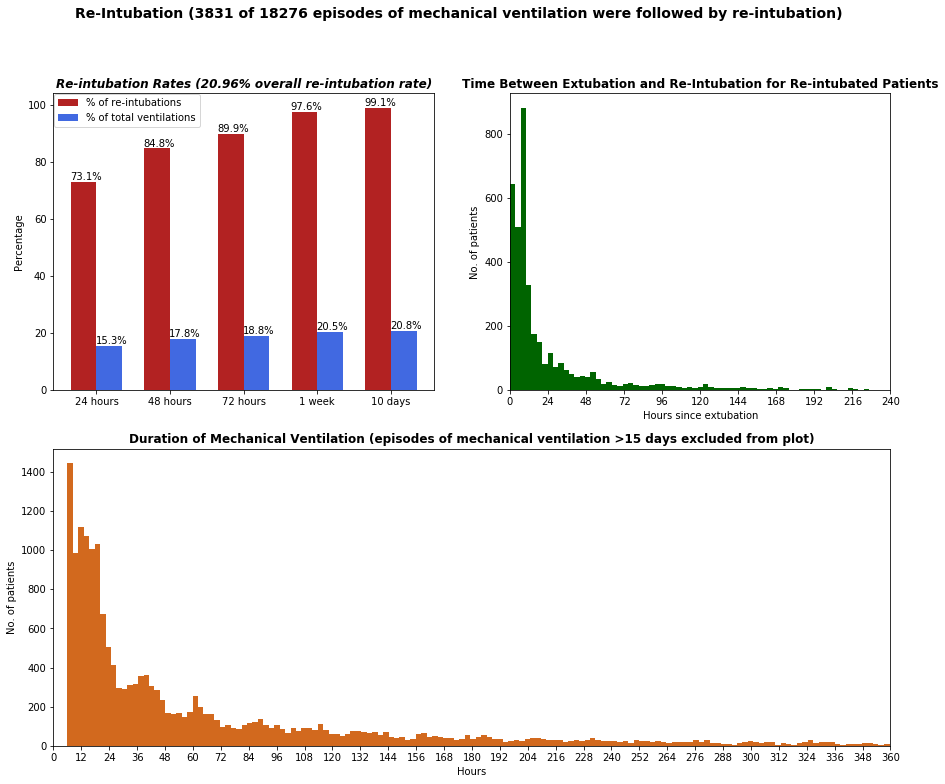

In [6]:
# Calculate statistics on re-intubation
n = len(ri_times)
re_int = n - sum(ri_times['timediff']==0)
ri_patients = ri_times[ri_times['timediff']>0]
_24h = len(ri_patients[ri_patients['timediff']<=24])
_48h = len(ri_patients[ri_patients['timediff']<=48])
_72h = len(ri_patients[ri_patients['timediff']<=72])
_7d = len(ri_patients[ri_patients['timediff']<=168])
_10d = len(ri_patients[ri_patients['timediff']<=240])

# Visualise re-intubation rates and re-intubation times
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2,2)
fig = plt.figure(figsize=(15,12))
fig.suptitle('Re-Intubation ({} of {} episodes of mechanical ventilation were followed by re-intubation)'.format(re_int, n), weight='semibold', fontsize=14)

# Plot the re-intubation rates
reintubations = [
    100 * _24h / len(ri_patients),
    100 * _48h / len(ri_patients),
    100 * _72h / len(ri_patients),
    100 * _7d / len(ri_patients),
    100 * _10d / len(ri_patients)
]
overalls = [
    100 * _24h / len(ri_times),
    100 * _48h / len(ri_times),
    100 * _72h / len(ri_times),
    100 * _7d / len(ri_times),
    100 * _10d / len(ri_times)
]
labels = ['24 hours', '48 hours', '72 hours', '1 week', '10 days']
x = np.arange(len(labels))
width = 0.35
ax1 = plt.subplot(gs[0,0])
bar1 = ax1.bar(x - width/2, reintubations, width, label='% of re-intubations', color='firebrick')
bar2 = ax1.bar(x + width/2, overalls, width, label='% of total ventilations', color='royalblue')
ax1.set_title('Re-intubation Rates ({:.2f}% overall re-intubation rate)'.format(100*re_int/n), style='italic', weight='semibold')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_ylabel('Percentage')
ax1.legend(loc='best', bbox_to_anchor=(0.398, 1.016, 0., 0.))

# Add a text label above bars in bar chart
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax1.annotate('{:.1f}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(2,0),  # 1 point vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(bar1)
autolabel(bar2)

# Plot the re-intubation times
ax2 = plt.subplot(gs[0,1])
ax2.hist(x=ri_patients['timediff'], bins=500, color='darkgreen')
ax2.set_title('Time Between Extubation and Re-Intubation for Re-intubated Patients', weight='semibold')
ax2.set_xlim([0,240])
ax2.set_xticks(range(0,241,24))
ax2.set_xlabel('Hours since extubation')
ax2.set_ylabel('No. of patients')

# Plot the ventilation durations
ax3 = plt.subplot(gs[1,:])
ax3.hist(x=mech_vent[(mech_vent['duration_hours']>=6) & (mech_vent['ventnum']==1)]['duration_hours'], bins=750, color='chocolate')
ax3.set_title('Duration of Mechanical Ventilation (episodes of mechanical ventilation >15 days excluded from plot)', weight='semibold')
ax3.set_xlim([0,360])
ax3.set_xticks(range(0,361,12))
ax3.set_xlabel('Hours')
ax3.set_ylabel('No. of patients')

# Save plot
plt.savefig('plots/reintubation.png');

In [7]:
# Define outcomes
ri_times['success'] = ri_times['ventsub']==0 # extubation success if they are never re-intubated
ri_times['failure'] = (ri_times['ventsub']>0) & (ri_times['timediff']<=48) # extubation failure if they are re-intubated within 48 hours

# Add ventilation outcomes to patient data
patients = patients.merge(ri_times[['icustay_id', 'success', 'failure']], on='icustay_id')

# Show some sample data
patients.head()

,subject_id,hadm_id,icustay_id,gender,dob,age,admittime,dischtime,intime,outtime,los,diagnosis,hospital_expire_flag,ventnum,success,failure
0,268,110404,280836,F,2132-02-21,65.98,2198-02-11 13:40:00,2198-02-18 03:55:00,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490,DYSPNEA,1,1,True,False
1,275,129886,219649,M,2088-08-07,82.16,2170-10-06 03:09:00,2170-10-19 15:35:00,2170-10-07 11:28:53,2170-10-14 14:38:07,7.1314,UROSEPSIS-CHANGE IN MENTAL STATUS,1,1,True,False
2,281,111199,257572,F,2041-10-12,60.02,2101-10-18 04:42:00,2101-10-25 19:10:00,2101-10-18 04:45:22,2101-10-25 22:29:25,7.7389,"PNEUMONIA,HYPONATREMIA",1,2,False,True
3,283,109185,231490,M,2090-09-05,75.93,2166-08-12 22:02:00,2166-09-12 14:41:00,2166-08-12 22:03:26,2166-09-12 14:41:42,30.6932,PNEUMONIA,0,2,False,True
4,285,165312,238023,M,2107-05-16,45.35,2152-09-21 22:47:00,2152-10-20 15:19:00,2152-09-21 22:48:50,2152-10-20 15:19:31,28.6880,SPINAL INJURY,0,1,True,False


In [8]:
# Save to re_intubation.npy
if not os.path.exists('./data'):
    os.makedirs('./data')

tosave = {'re_intubation': ri_times, 'patients': patients}
np.save('data/re_intubation.npy',tosave)
print("Saved!")

Saved!
